# Dimensionality of galaxies

The question I try to answer is: how many variables are required to fully describe a galaxy. A followup question is then, which variables best encodes this (for example: stellar mass, angular momentum, SFR, ...).

## Simple example: pendulum
Let us start with an example. Let us focus on the dynamics of a pendulum. One could measure multiple variables defining the state of the pendulum: its `x`, `y`, `z` positions, its mass, the length of the arm, the angle with respect to vertical, ... If we have $M$ observations of the pendulum, we can write its state at each of the $M$ steps as
$$ \mathbf{S}_i = \{q_1, \dots, q_N\},$$
where $i=1,\dots,M$ and $N$ is the number of variables describing the state of the pendulum.

Now for a given pendulum, we know the only free dimension is its angle with respect to the vertical, which means that each data point $\mathbf{S}_i$ actually leaves on a 1D manifold embedded in the $M$ dimensions we observe.

## Method
Following the example of the pendulum, imagine we do not know the physics of the pendulum. Is there a way to tell from the data that a pendulum is parametrized by a single variable?

This amounts to measuring the dimensionality of our cloud of $N$-dimensional points. Here, I propose to measure this value as follows:
1. Map all dimensions of our datapoint to be the range $[0, 1]$ (eventually using the logarithm of the dimension).
2. Build a graph. Insert each datapoint as one node. For each point, finds its $k$-nearest neighbours in $N$ dimensions and create edges between them. $k$ should be large enough for the graph to be fully connected.
3. Draw random nodes in the graph and compute the number of nodes $n(i)$ within $i$ hops from it. This number scales as $n(i) = i^d$, where $d$ is the **dimensionality** of the graph

## Remaining to be solved

- [ ] Where to measure dimensionality? The method seems to work (see below), as per point 3 above, the dimensionality can be measured as a function of the number of hops / the distance in the graph. But at what distance should this be measured?
- [ ] How can we prevent noise from “increasing” the dimensionality?

In [1]:
from typing import Optional

import joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from astropy.io import fits
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.spatial import cKDTree as KDTree
from tqdm.auto import tqdm

from astrophysics_toolset.io.yorick import PDBReader
from astrophysics_toolset.utilities.logging import logger

plt.rcParams["figure.dpi"] = 180

In [2]:
def _find_dimensionality_helper(
    *, inode: int, G: nx.Graph, distances: np.ndarray
) -> np.ndarray:
    N = np.zeros(len(distances))
    Gprev = G
    for i, d in enumerate(distances):
        logger.debug("Building ego graph from distance %s", d)
        Gprev = nx.ego_graph(Gprev, inode, radius=d, distance="weight")
        N[i] = len(Gprev.nodes)

    return N


def find_dimensionality(
    data: np.ndarray,
    Nsample: int = 100,
    bins: Optional[np.ndarray] = None,
    use_MST: bool = False,
    min_neigh: int = 5,
    max_neigh: int = 30,
    n_jobs=-1,
    n_min_connected_components: int = 5,
):
    """Find the dimensionality of the manifold on which data reside.

    Parameters
    ----------
    data : ndarray, shape (n, m)
        n samples of m features
    Nsample : int
        The number of samples to draw to estimate the dimensionality.
    bins : array
        The distance arrays to use when computing the distance
    use_MST : bool
        If True, use a Minimum Spanning Tree instead of the full graph. May be
        faster, but potentially lead to wrong answer.
    min_neigh, max_neigh : int
        Minimum and maximum number of nearest-neighbours to use when creating
        graph edges.
    n_min_connected_components : int
        As long as the number of connected components if below this value, keep
        on adding edges to the graph.
    Returns
    -------
    N : array (Nsample, Nbins)
        The number of elements in the graph
    distances : array (Nbins, )
        The distances.

    Notes
    -----

    1. The dimensionality can be obtained by computing dlog N/dlog distances, which
       should be an integer number.
    2. It is highly advised to scale the input data so that the dynamical range of
       all features is the same, preferably between 0 and 1.

    The algorithm works as follows:
    1. A nearest-neighbour graph is computed, with a number of neighbours large enough so
       that the graph is fully connected.
    2. Optionaly, the graph is reduced using a minimum-spanning tree approach.
    3. Randomly selected points are drawn from the graph and the number of connected points
       within some given distance (along graph edges) is computed. This number scales as
       r^dimensionality.

    """
    logger.info("Building KD-tree")
    tree = KDTree(data)

    logger.info("Finding nearest neighbours")

    d, ineigh = tree.query(
        tree.data, k=max_neigh + 1, workers=-1
    )  # +1 since the 0-th is itself

    logger.info("Building graph")
    G = nx.Graph()
    G.add_nodes_from((i, {"pos": data[i]}) for i in ineigh[:, 0])

    logger.info("Adding edges until graph is connected")
    connected = False
    do_once_more = min_neigh == 1
    i = min_neigh
    while not connected or do_once_more:
        if i >= max_neigh:
            logger.error(
                "Could not compute a connected graph using %s nearest neighbour."
                "The current graph has %s distinct components",
                max_neigh,
                nx.components.number_connected_components(G),
            )
            break
        edges = (
            (a, b, d) for a, b, d in zip(ineigh[:, 0], ineigh[:, i + 1], d[:, i + 1])
        )
        G.add_weighted_edges_from(edges)

        if do_once_more:
            logger.debug("n_neigh%s: ✔", i)
            break

        if nx.connected.number_connected_components(G) <= n_min_connected_components:
            logger.debug("n_neigh%s: ✔", i)
            connected = True
            do_once_more = True
            break
            # i *= 2
        else:
            logger.debug("n_neigh%s: ✖", i)
            i += 1

    if use_MST:
        logger.info("Computing minimum spanning tree")
        GMST = nx.algorithms.minimum_spanning_tree(G)
        G = GMST

    logger.info("Computing number of point as a function of distance")
    # Use decreasing distance, so that the ego graph at step i+1 is fully contained in the one at step i (huge improvement!)
    distances = bins if bins is not None else np.geomspace(0.01, 2, 40)

    # Sort by decreasing distances
    distances = np.sort(distances)[::-1]

    N = np.zeros((len(distances), Nsample))

    data = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(_find_dimensionality_helper)(
            inode=inode,
            G=G,
            distances=distances,
        )
        for inode in tqdm(
            np.random.choice(len(data), size=Nsample, replace=False), desc="Sampling"
        )
    )

    for istep, dt in enumerate(data):
        N[:, istep] += dt

    return N, distances

In [3]:
def normalize_log(a):
    b = np.log10(a)
    return normalize_lin(b)


def normalize_lin(a):
    mask = np.isfinite(a)
    amin, amax = np.min(a[mask]), np.max(a[mask])
    tmp = (a - amin) / (amax - amin)
    return np.where(np.isfinite(tmp), tmp, 0)

# Simple case: the U-shape

As a first example, I draw points from a $U$ curve (one dimension). The goal is to find a value of one.

Text(0, 0.5, 'y')

<Figure size 1080x720 with 1 Axes>

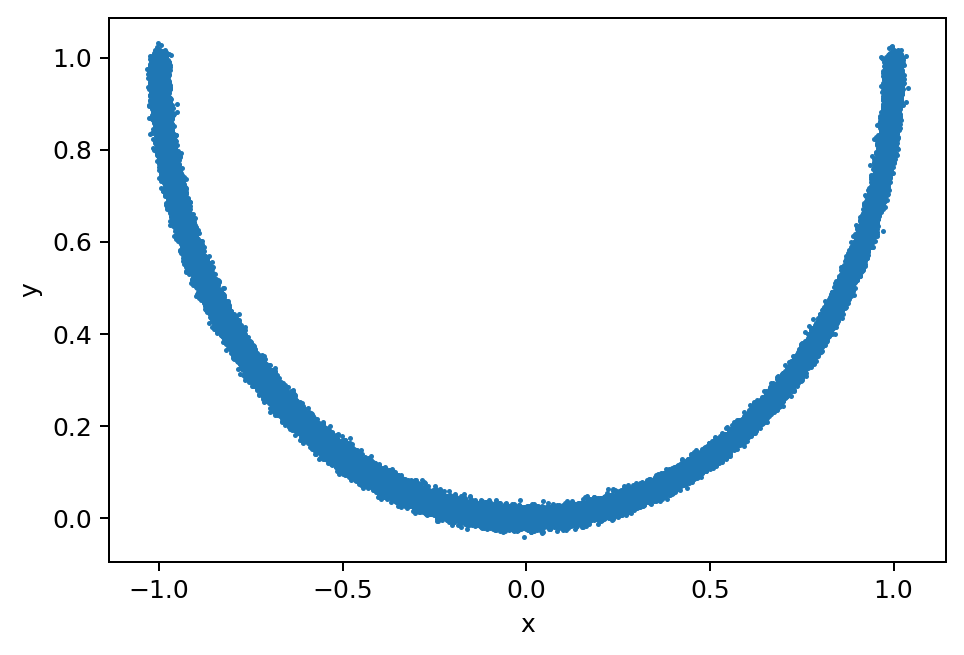

In [4]:
s = np.random.rand(100_000) * np.pi
x = np.cos(s)
y = 1 - np.sin(s)
z = np.cos(2 * np.pi * s)

# Add some noise
mu = [0, 0]
ss = 0.0001
Sigma = np.array([ss, ss / 4, ss / 4, ss]).reshape(2, 2)
noise = np.random.multivariate_normal(mu, Sigma, size=x.size)
x += noise[:, 0]
y += noise[:, 1]

data = np.stack([x, y, z], axis=-1)
plt.scatter(x, y, s=1)
plt.xlabel("x")
plt.ylabel("y")

## Without using minimum-spanning tree

In [6]:
Nsample = 20

N, distances = find_dimensionality(data, Nsample=Nsample)
dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(distances))[:, None]

  0%|          | 0/20 [00:00<?, ?it/s]

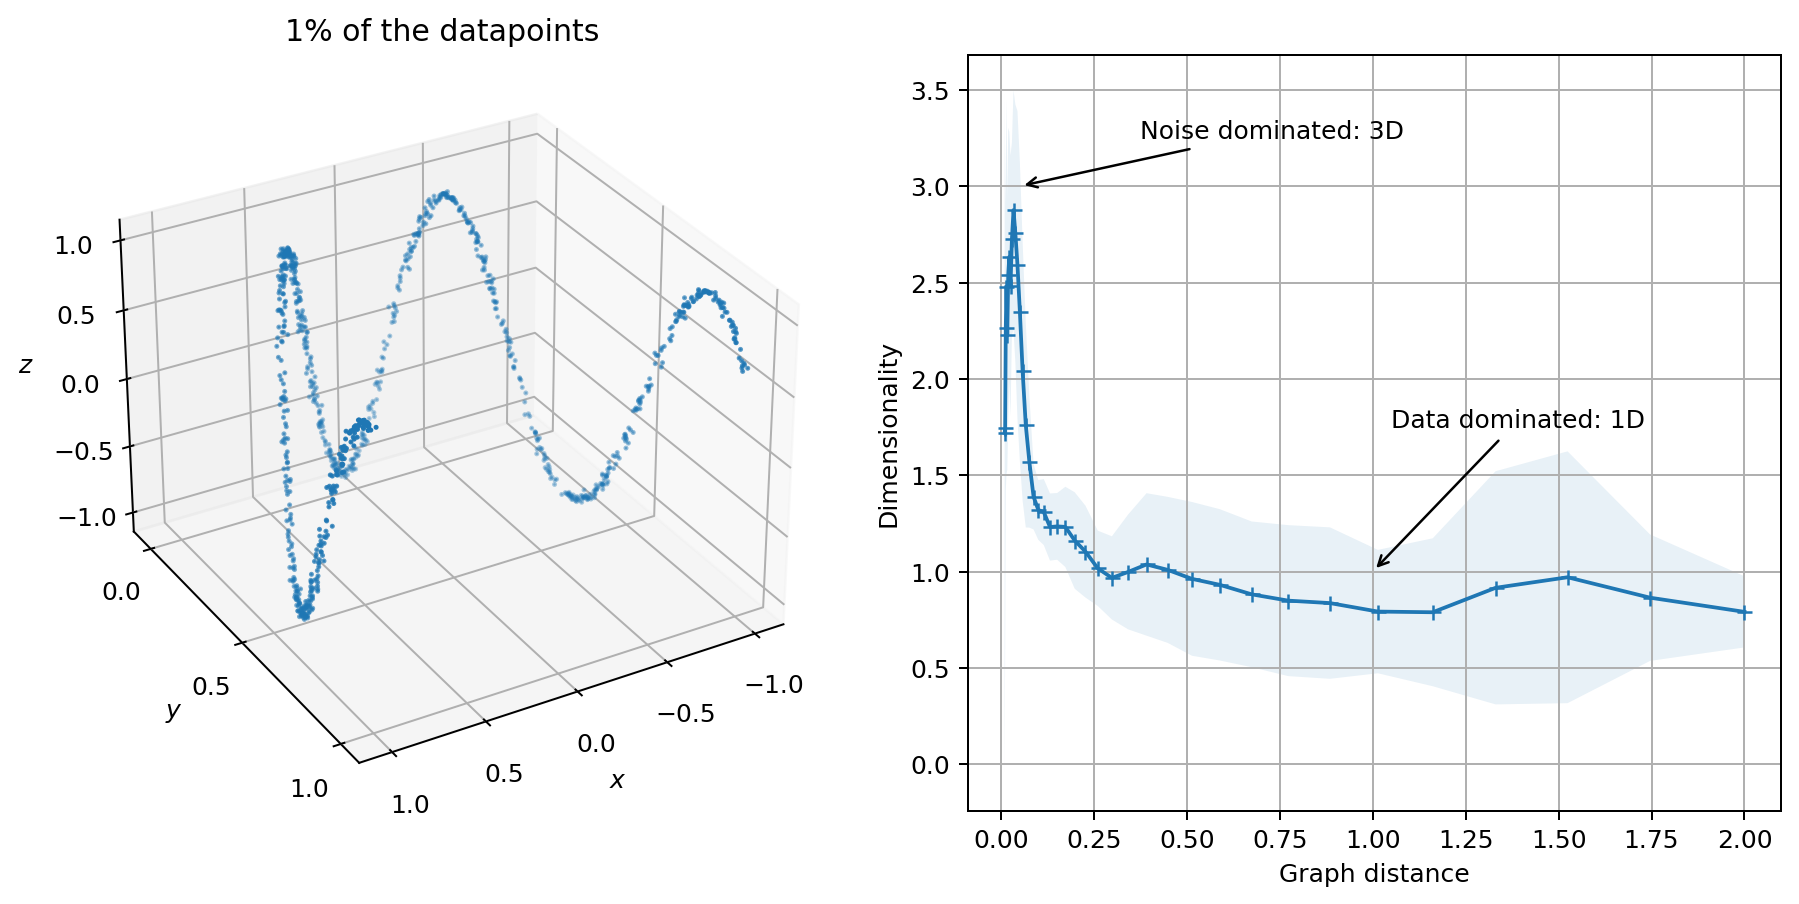

In [23]:
mu = dN_dd.mean(axis=1)
std = dN_dd.std(axis=1)
fig = plt.figure(figsize=(10, 5), dpi=180)

ax = fig.add_subplot(121, projection="3d")
ax.scatter(data[::100, 0], data[::100, 1], data[::100, 2], s=1, marker="o")
ax.view_init(30, 60)
ax.set(
    xlabel="$x$",
    ylabel="$y$",
    zlabel="$z$",
)
for k in "xyz":
    ticks = np.array([-1, -0.5, 0, 0.5, 1])
    vmin, vmax = getattr(ax, f"get_{k}lim")()
    getattr(ax, f"set_{k}ticks")(ticks[(ticks >= vmin) & (ticks <= vmax)])

plt.title("1% of the datapoints")

ax = fig.add_subplot(122)
# plt.axvline(np.sqrt(Sigma[0,0]))
ax.plot(distances, mu, "-+")
ax.fill_between(distances, mu - std, mu + std, alpha=0.1)
ax.grid(True)
ax.annotate(
    "Noise dominated: 3D",
    (0.05, 3),
    xytext=(0.375, 3.25),
    arrowprops={"arrowstyle": "->"},
)
ax.annotate(
    "Data dominated: 1D", (1, 1), xytext=(1.05, 1.75), arrowprops={"arrowstyle": "->"}
)

ax.set(xlabel="Graph distance", ylabel="Dimensionality")
plt.tight_layout()

In the example above, we find as expected a dimensionality of $1$ (note that the error bars depend on the number of sample drawn to estimate the dimensionality, here 20).

## Using minimum spanning tree
After we have built the graph, we can trim it using a minimum spanning tree to remove extraneous edges. Let us check this works

In [26]:
N, distances = find_dimensionality(data, Nsample=20, use_MST=True)
dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(distances))[:, None]

astrophyics_toolset: [INFO     ] 2022-03-24 17:33:54,857 Building KD-tree
astrophyics_toolset: [INFO     ] 2022-03-24 17:33:54,898 Finding nearest neighbours
astrophyics_toolset: [INFO     ] 2022-03-24 17:33:55,177 Building graph
astrophyics_toolset: [INFO     ] 2022-03-24 17:33:55,324 Adding edges until graph is connected
astrophyics_toolset: [INFO     ] 2022-03-24 17:33:56,503 Computing minimum spanning tree
astrophyics_toolset: [INFO     ] 2022-03-24 17:33:58,799 Computing number of point as a function of distance


  0%|          | 0/20 [00:00<?, ?it/s]

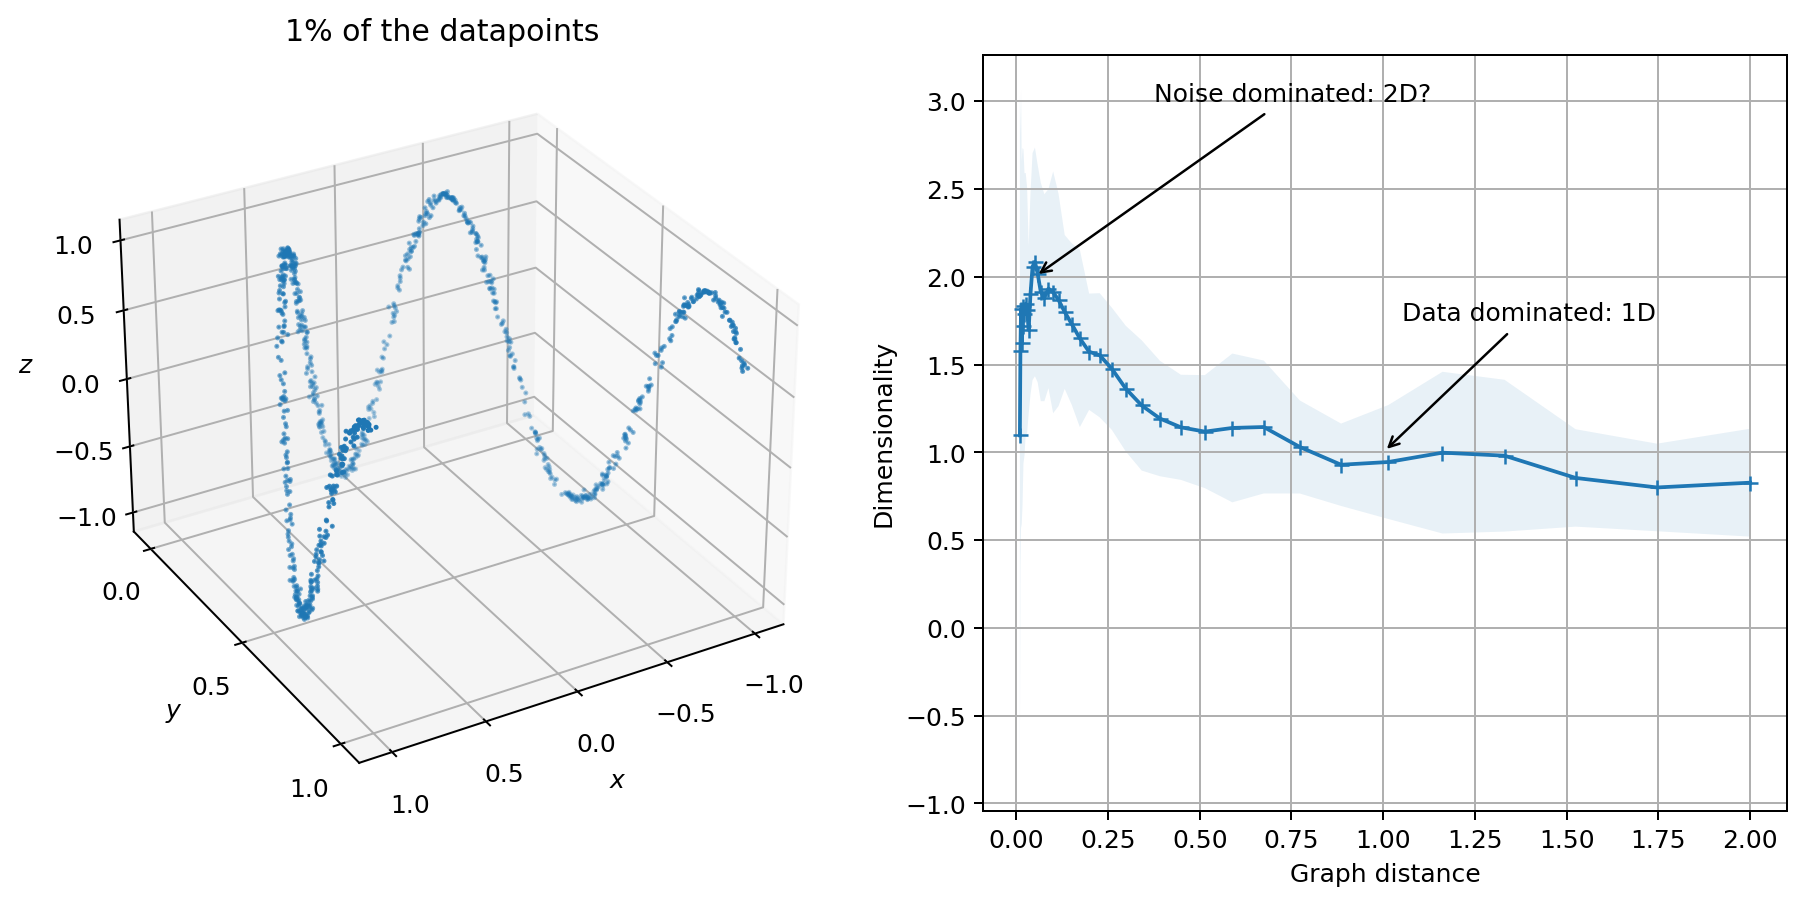

In [28]:
mu = dN_dd.mean(axis=1)
std = dN_dd.std(axis=1)
fig = plt.figure(figsize=(10, 5), dpi=180)

ax = fig.add_subplot(121, projection="3d")
ax.scatter(data[::100, 0], data[::100, 1], data[::100, 2], s=1, marker="o")
ax.view_init(30, 60)
ax.set(
    xlabel="$x$",
    ylabel="$y$",
    zlabel="$z$",
)
for k in "xyz":
    ticks = np.array([-1, -0.5, 0, 0.5, 1])
    vmin, vmax = getattr(ax, f"get_{k}lim")()
    getattr(ax, f"set_{k}ticks")(ticks[(ticks >= vmin) & (ticks <= vmax)])

plt.title("1% of the datapoints")

ax = fig.add_subplot(122)
# plt.axvline(np.sqrt(Sigma[0,0]))
ax.plot(distances, mu, "-+")
ax.fill_between(distances, mu - std, mu + std, alpha=0.1)
ax.grid(True)
ax.annotate(
    "Noise dominated: 2D?",
    (0.05, 2),
    xytext=(0.375, 3.0),
    arrowprops={"arrowstyle": "->"},
)
ax.annotate(
    "Data dominated: 1D", (1, 1), xytext=(1.05, 1.75), arrowprops={"arrowstyle": "->"}
)

ax.set(xlabel="Graph distance", ylabel="Dimensionality")
plt.tight_layout()

# Slightly more complex curves

This is now a 2D manifold embedded in 3D

## Swiss roll

In [31]:
from sklearn import datasets

X, color = datasets.make_s_curve(n_samples=200_000, noise=0.01)
x, y, z = X.T

[Text(0.5, 1.0, 'density'), Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

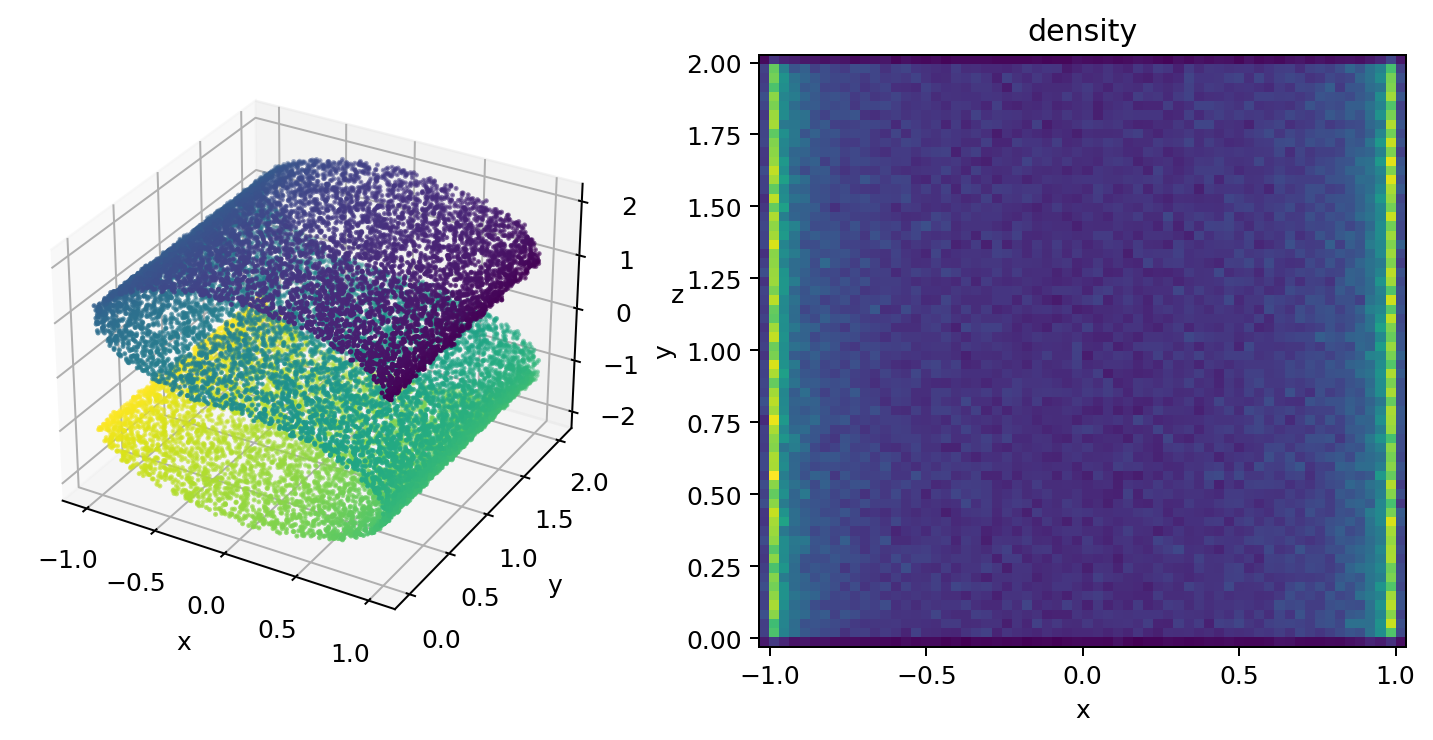

In [38]:
data = np.stack([x, y, z], axis=-1)
fig = plt.figure(figsize=(8, 4), constrained_layout=True)
ax = fig.add_subplot(121, projection="3d")
ax.scatter(x[::10], y[::10], z[::10], s=1, c=color[::10])
ax.set(
    xlabel="x",
    ylabel="y",
    zlabel="z",
)

ax = plt.subplot(122)
ax.hist2d(x[::1], y[::1], bins=64)
ax.set(
    title="density",
    xlabel="x",
    ylabel="y",
)

In [39]:
N, distances = find_dimensionality(data, Nsample=20, n_jobs=3)
dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(distances))[:, None]

astrophyics_toolset: [INFO     ] 2022-03-24 17:40:06,209 Building KD-tree
astrophyics_toolset: [INFO     ] 2022-03-24 17:40:06,306 Finding nearest neighbours
astrophyics_toolset: [INFO     ] 2022-03-24 17:40:06,669 Building graph
astrophyics_toolset: [INFO     ] 2022-03-24 17:40:07,065 Adding edges until graph is connected
astrophyics_toolset: [INFO     ] 2022-03-24 17:40:09,479 Computing number of point as a function of distance


  0%|          | 0/20 [00:00<?, ?it/s]

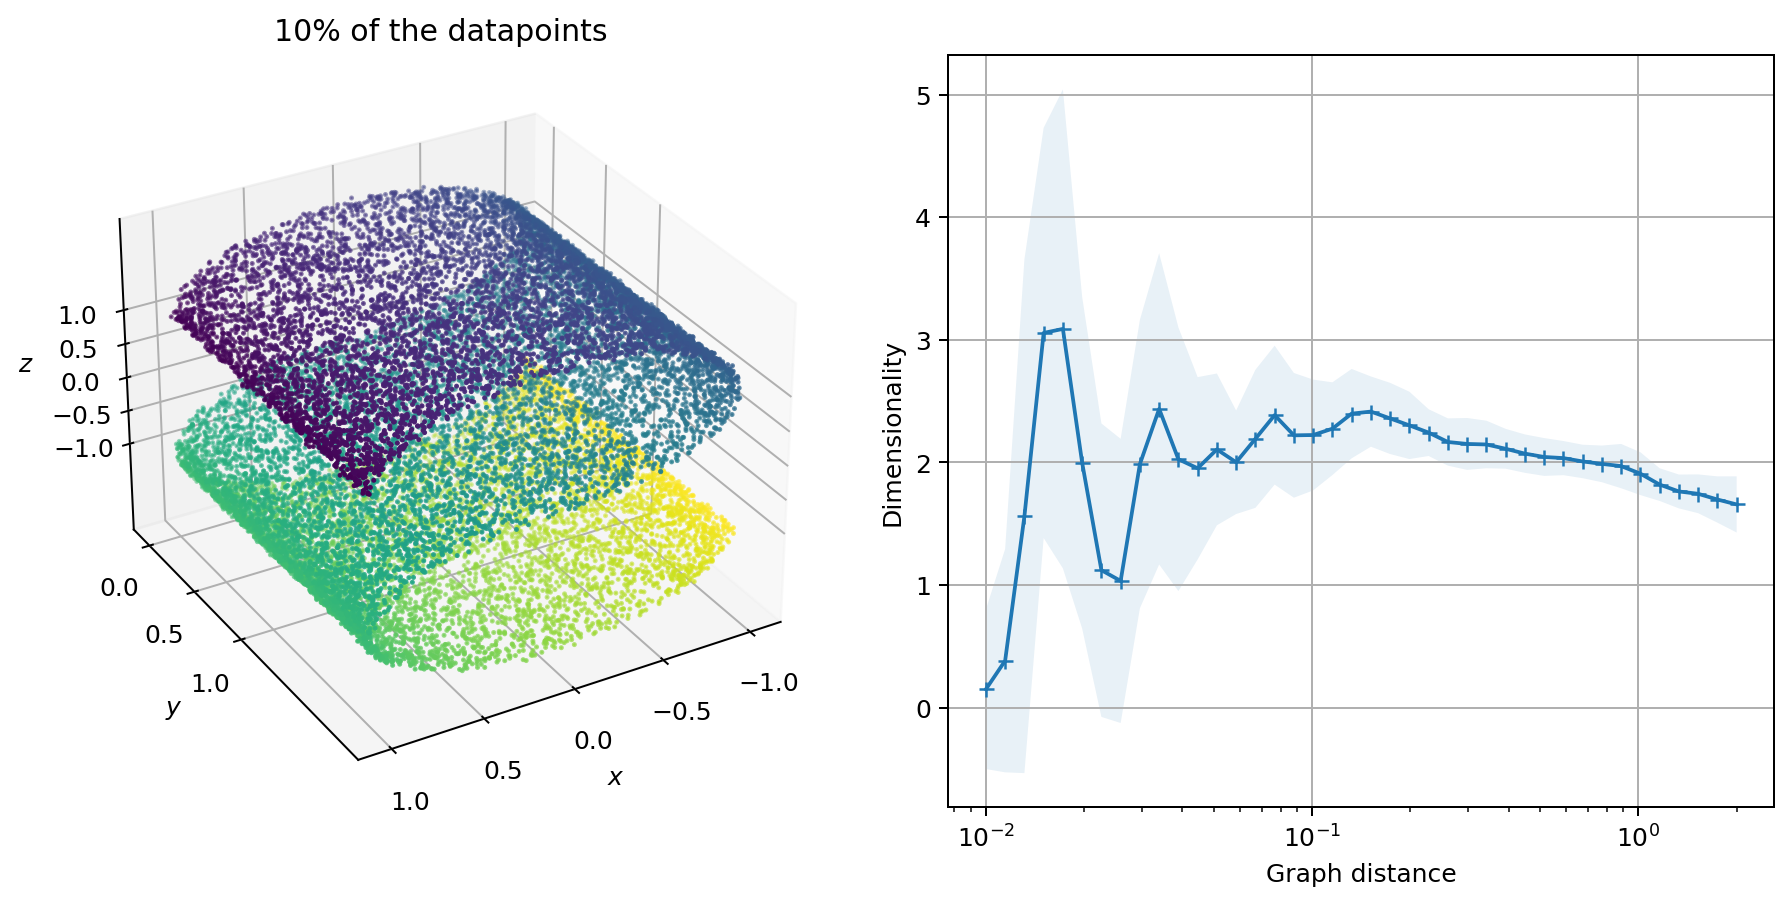

In [40]:
mu = dN_dd.mean(axis=1)
std = dN_dd.std(axis=1)
fig = plt.figure(figsize=(10, 5), dpi=180)

ax = fig.add_subplot(121, projection="3d")
sl = slice(None, None, 10)
ax.scatter(data[sl, 0], data[sl, 1], data[sl, 2], s=1, marker="o", c=color[sl])
ax.view_init(30, 60)
ax.set(
    xlabel="$x$",
    ylabel="$y$",
    zlabel="$z$",
)
for k in "xyz":
    ticks = np.array([-1, -0.5, 0, 0.5, 1])
    vmin, vmax = getattr(ax, f"get_{k}lim")()
    getattr(ax, f"set_{k}ticks")(ticks[(ticks >= vmin) & (ticks <= vmax)])
plt.title("10% of the datapoints")

ax = fig.add_subplot(122)
ax.plot(distances, mu, "-+")
ax.fill_between(distances, mu - std, mu + std, alpha=0.1)
ax.grid(True)

ax.set(xlabel="Graph distance", ylabel="Dimensionality", xscale="log")
plt.tight_layout()

In [ ]:
x = distances
y = np.mean(np.gradient(N, axis=0) / np.gradient(distances)[:, None], axis=1)

imax = np.argmax(y)
xmax, ymax = x[imax], y[imax]

fix, ax = plt.subplots()
ax.loglog(x / xmax, y / ymax, label="Data", c="black")

for dim in range(1, 4):
    xx = x / xmax * np.pi / 2
    ax.loglog(
        x / xmax, np.sin(xx) ** (dim - 1), ls="--", label=rf"$N_\mathrm{{dim}}={dim}$"
    )

ax.set(
    xlabel=r"$r/r_\mathrm{max}$",
    ylabel=r"$p/p_\mathrm{max}$",
)
ax.grid(True)
ax.legend()

## $N$-Möbius strip

In [100]:
w = 1
R = 4
N = 100_000
n = 2 / 10

noise_lvl = w / 10

s = np.random.uniform(-w, w, size=N)
t = np.random.uniform(0, 2 * np.pi, size=N)

x = (R + s * np.cos(t / n)) * np.cos(t) + np.random.rand(N) * noise_lvl
y = (R + s * np.cos(t / n)) * np.sin(t) + np.random.rand(N) * noise_lvl
z = s * np.sin(t / n) + np.random.rand(N) * noise_lvl

data = np.stack([x, y, z], axis=-1)

[Text(0.5, 0, '$x$'), Text(0.5, 0, '$y$'), Text(0.5, 0, '$z$')]

<Figure size 1800x900 with 1 Axes>

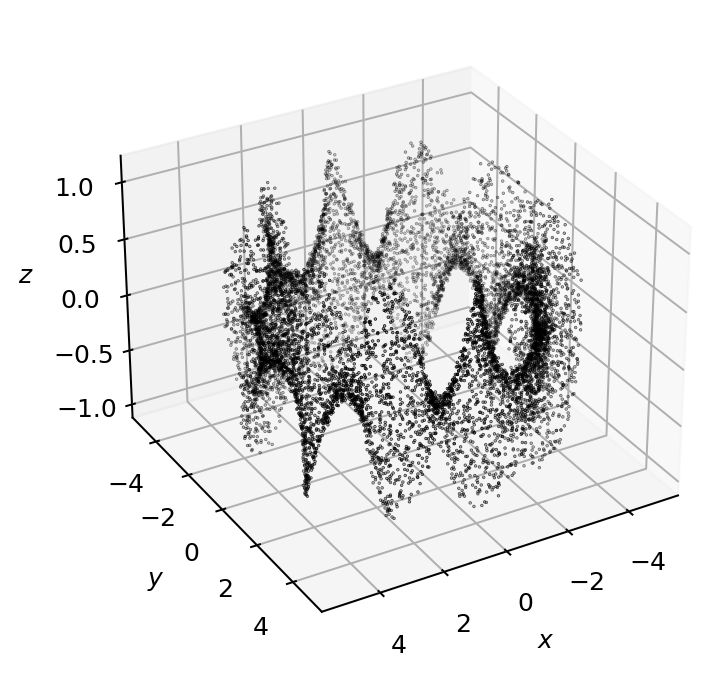

In [110]:
fig = plt.figure(figsize=(10, 5), dpi=180)

ax = fig.add_subplot(121, projection="3d")
sl = slice(None, None, 10)
ax.scatter(data[sl, 0], data[sl, 1], data[sl, 2], s=0.1, marker="o", c="k")
ax.view_init(30, 60)
ax.set(
    xlabel="$x$",
    ylabel="$y$",
    zlabel="$z$",
)

In [114]:
N, distances = find_dimensionality(
    data,
    Nsample=20,
    n_jobs=8,
    bins=np.geomspace(1e-2, 10, 50),
    n_min_connected_components=1,
)
dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(distances))[:, None]

astrophyics_toolset: [INFO     ] 2022-04-12 17:08:26,263 Building KD-tree
astrophyics_toolset: [INFO     ] 2022-04-12 17:08:26,435 Finding nearest neighbours
astrophyics_toolset: [INFO     ] 2022-04-12 17:08:26,919 Building graph
astrophyics_toolset: [INFO     ] 2022-04-12 17:08:27,272 Adding edges until graph is connected
astrophyics_toolset: [DEBUG    ] 2022-04-12 17:08:28,109 n_neigh5: ✖
astrophyics_toolset: [DEBUG    ] 2022-04-12 17:08:28,579 n_neigh6: ✔
astrophyics_toolset: [INFO     ] 2022-04-12 17:08:28,580 Computing number of point as a function of distance


Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

<Figure size 1800x900 with 2 Axes>

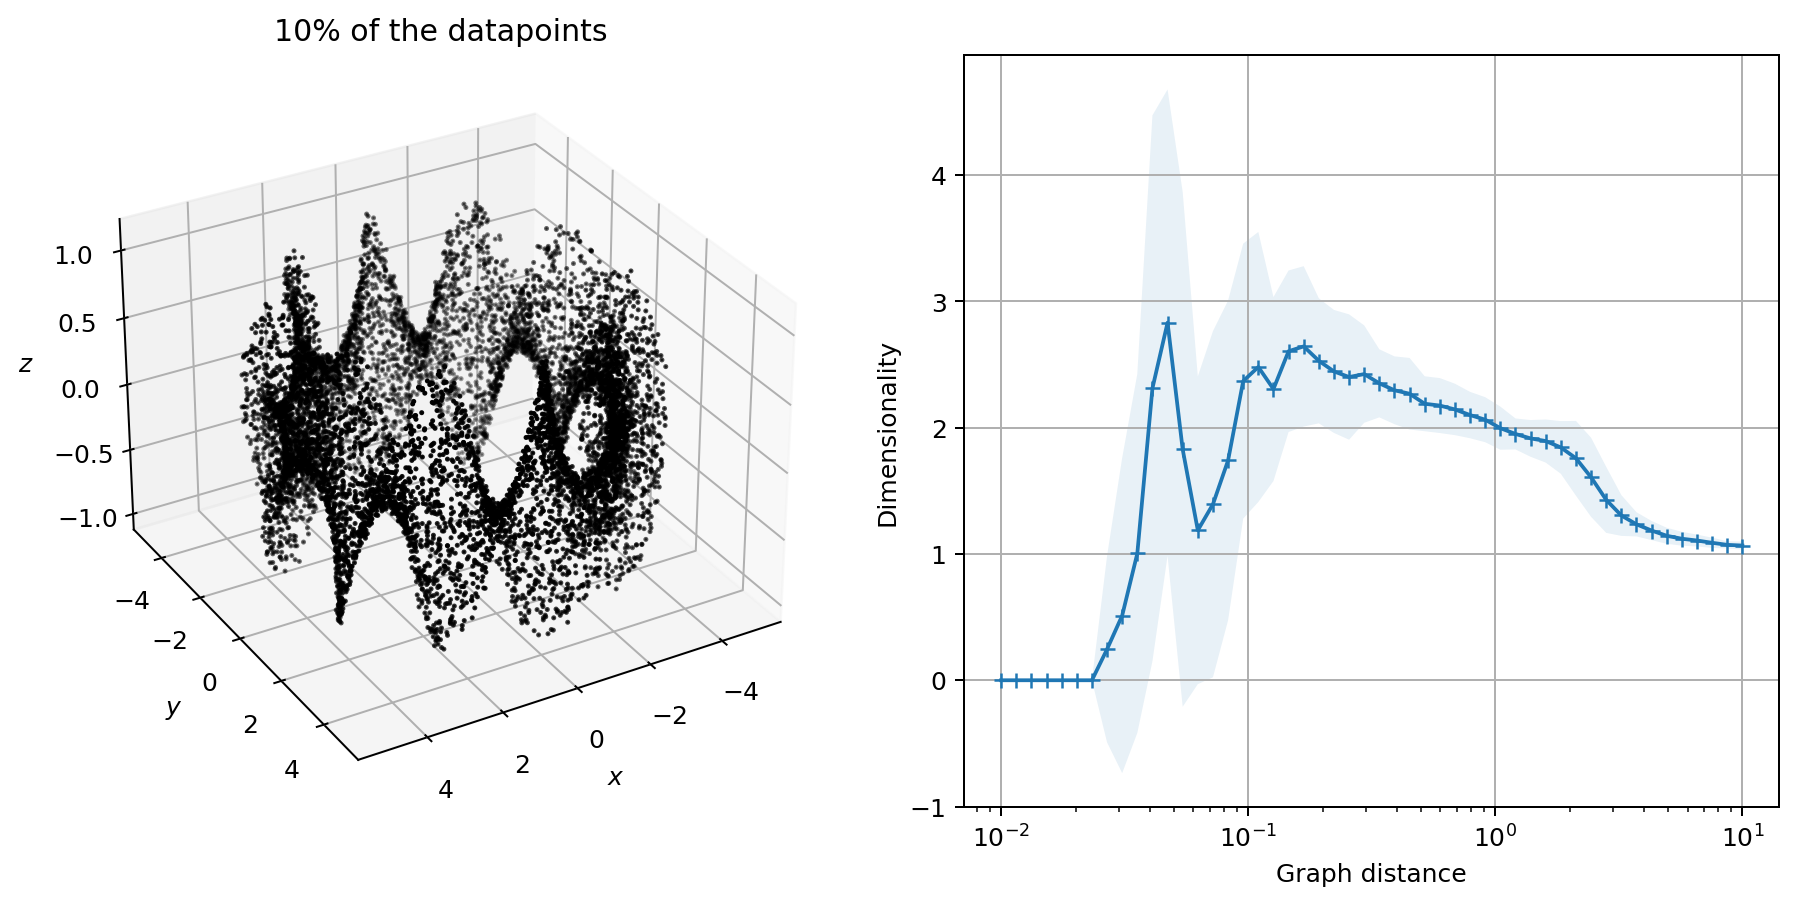

In [115]:
mu = dN_dd.mean(axis=1)
std = dN_dd.std(axis=1)
fig = plt.figure(figsize=(10, 5), dpi=180)

ax = fig.add_subplot(121, projection="3d")
sl = slice(None, None, 10)
ax.scatter(data[sl, 0], data[sl, 1], data[sl, 2], s=1, marker="o", c="k")
ax.view_init(30, 60)
ax.set(
    xlabel="$x$",
    ylabel="$y$",
    zlabel="$z$",
)

plt.title("10% of the datapoints")

ax = fig.add_subplot(122)
ax.plot(distances, mu, "-+")
ax.fill_between(distances, mu - std, mu + std, alpha=0.1)
ax.grid(True)

ax.set(xlabel="Graph distance", ylabel="Dimensionality", xscale="log")
plt.tight_layout()

<matplotlib.legend.Legend object at 0x7fd926aa4f10>

<Figure size 1080x720 with 1 Axes>

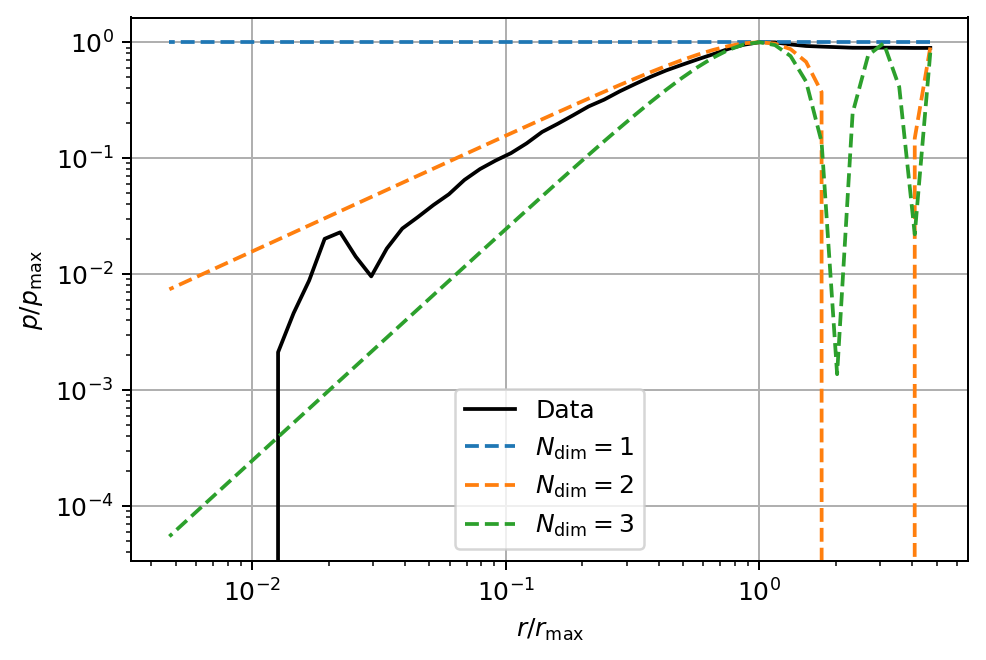

In [116]:
x = distances
y = np.mean(np.gradient(N, axis=0) / np.gradient(distances)[:, None], axis=1)

imax = np.argmax(y)
xmax, ymax = x[imax], y[imax]

fix, ax = plt.subplots()
ax.loglog(x / xmax, y / ymax, label="Data", c="black")

for dim in range(1, 4):
    xx = x / xmax * np.pi / 2
    ax.loglog(
        x / xmax, np.sin(xx) ** (dim - 1), ls="--", label=rf"$N_\mathrm{{dim}}={dim}$"
    )

ax.set(
    xlabel=r"$r/r_\mathrm{max}$",
    ylabel=r"$p/p_\mathrm{max}$",
)
ax.grid(True)
ax.legend()

# Actual data from H-AGN simulation

## Data from Horizon-AGN

In [5]:
from astrophysics_toolset.io import yorick

In [42]:
%bash rsync -azz --progress infinity:"/data65/laigle/Hz-AGNCub/galaxies-782.pdb" tmp

receiving incremental file list


In [6]:
p = yorick.PDBReader("tmp/galaxies-782.pdb")

In [7]:
def walk(node, prefix=None):
    if prefix is None:
        prefix = []
    for k, v in node.items():
        if isinstance(v, dict):
            yield from walk(v, prefix + [k])
            continue

        if isinstance(v, tuple):
            typ, _ = v
        else:
            typ = v
        if typ in (int, float):
            yield prefix + [k]

In [8]:
dt = {}
for k in ("/".join(_) for _ in walk(p.structure)):
    tmp = p[k]
    if p[k].ndim > 1 and p[k].shape[1] == 3:
        for idim, dim in enumerate("xyz"):
            dt[f"{k}_{dim}"] = p[k][:, idim]
    elif p[k].ndim == 1:
        dt[k] = p[k]

In [9]:
df = pd.DataFrame(dt)
ok_columns = df.max() != df.min()

In [48]:
all_data = df.loc[:, ok_columns]

q1, q5, q9 = all_data.quantile(q=[0.1, 0.5, 0.9]).values

We remap all columns to a value in $[0,1]$ using either a linear or a logarithmic mapping (depending on the dynamical range).

In [49]:
all_data.apply(normalize_lin, axis=0).describe()

,catalog/vir/rvir,catalog/vir/mvir,catalog/vir/tvir,catalog/vir/cvel,catalog/shape_x,catalog/shape_y,catalog/shape_z,catalog/pos_x,catalog/pos_y,catalog/pos_z,...,catalog/mass,catalog/rad,catalog/spin,catalog/ek,catalog/ep,catalog/et,catalog/npart,catalog/bulge_x,catalog/bulge_y,catalog/bulge_z
count,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000,...,124744.000000,124744.000000,124744.000000,1.247440e+05,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000,124744.000000
mean,0.057900,0.002422,0.022363,0.108543,0.024459,0.037927,0.044285,0.485433,0.486957,0.494846,...,0.002378,0.026066,0.000154,7.256845e-05,0.999374,0.000056,0.002365,0.043725,0.045954,0.002227
std,0.043882,0.009430,0.034284,0.086753,0.016497,0.023770,0.026992,0.290390,0.280997,0.283850,...,0.009427,0.024836,0.004104,3.193450e-03,0.014501,0.003119,0.009392,0.026669,0.028454,0.008747
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.037593,0.000138,0.003339,0.043689,0.017725,0.028112,0.032600,0.232612,0.242680,0.261060,...,0.000107,0.016159,0.000026,3.097638e-07,0.999942,0.000004,0.000106,0.028243,0.030256,0.000111
50%,0.046540,0.000425,0.008973,0.080280,0.021646,0.033736,0.039364,0.456954,0.485953,0.496777,...,0.000392,0.020032,0.000038,1.551481e-06,0.999995,0.000005,0.000392,0.036919,0.039036,0.000390
75%,0.060935,0.001596,0.026437,0.148671,0.026410,0.040729,0.047686,0.740689,0.720496,0.714819,...,0.001557,0.026803,0.000060,1.042260e-05,0.999999,0.000011,0.001552,0.051902,0.053639,0.001507
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
data = np.stack(
    [
        normalize_log(np.abs(dt[f"catalog/{key}"]))
        for key in (
            "vir/rvir",
            "vir/mvir",
            "vir/tvir",
            "vir/cvel",
            "spin",
            "ek",
            "ep",
            "et",
        )
    ],
    axis=-1,
)

Text(0, 0.5, 'Count')

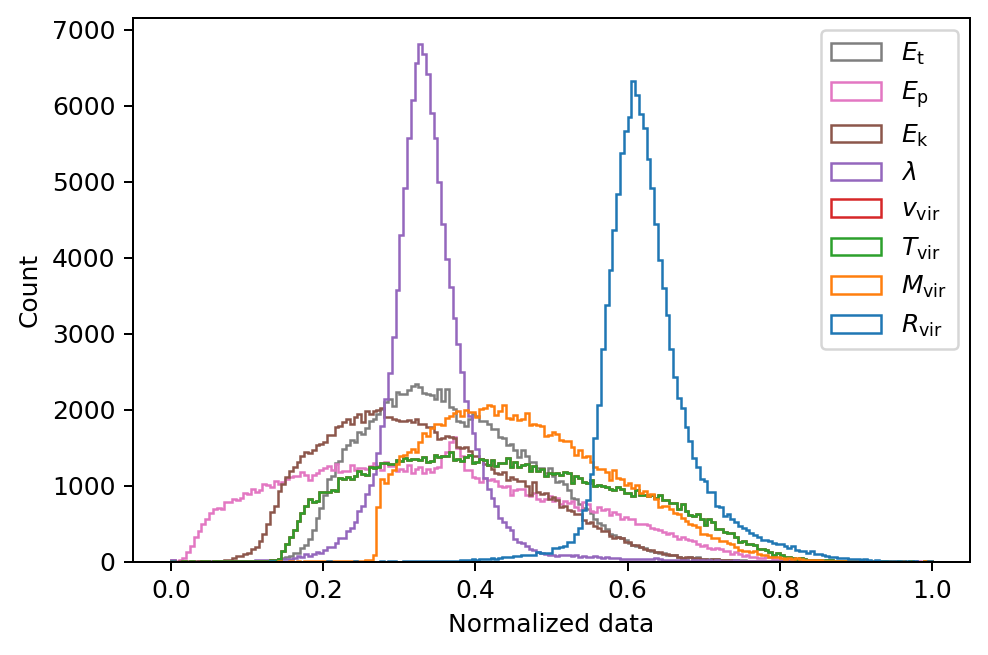

In [51]:
plt.hist(
    data,
    bins=200,
    histtype="step",
    label=r"$R_{\mathrm{vir}}$ $M_{\mathrm{vir}}$ $T_{\mathrm{vir}}$ $v_{\mathrm{vir}}$ $\lambda$ $E_\mathrm{k}$ $E_\mathrm{p}$ $E_\mathrm{t}$".split(),
)
plt.legend()
plt.xlabel("Normalized data")
plt.ylabel("Count")

In [52]:
N, d = find_dimensionality(data, Nsample=20, bins=np.geomspace(8e-3, 0.5, 20), n_jobs=3)

dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(d))[:, None]

astrophyics_toolset: [INFO     ] 2022-03-24 17:46:33,578 Building KD-tree
astrophyics_toolset: [INFO     ] 2022-03-24 17:46:33,653 Finding nearest neighbours
astrophyics_toolset: [INFO     ] 2022-03-24 17:46:35,408 Building graph
astrophyics_toolset: [INFO     ] 2022-03-24 17:46:35,643 Adding edges until graph is connected
astrophyics_toolset: [INFO     ] 2022-03-24 17:46:37,200 Computing number of point as a function of distance


  0%|          | 0/20 [00:00<?, ?it/s]

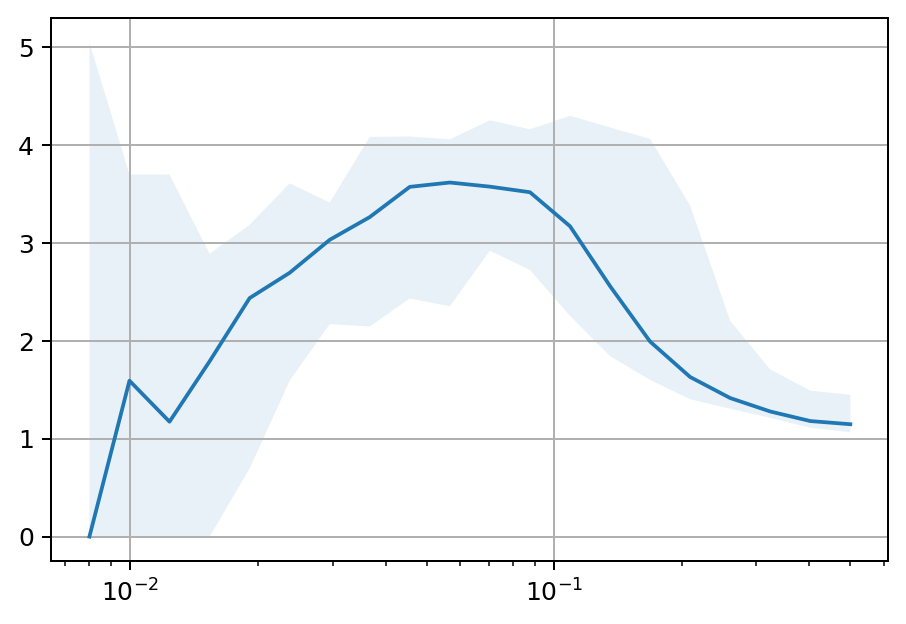

In [53]:
ylow, ymed, yup = np.percentile(dN_dd, q=(10, 50, 90), axis=1)
plt.plot(d, ymed)
plt.fill_between(d, ylow, yup, alpha=0.1)

plt.xscale("log")
plt.grid(True)

In [54]:
from IPython.display import Markdown as md

md(
    f"The initial dimensionality is {data.shape[1]}. From the look of the plot below, it seems that the intrinsic dimensionality is 3-4."
)

The initial dimensionality is 8. From the look of the plot below, it seems that the intrinsic dimensionality is 3-4.

## Data from H-AGN lightcone

In [6]:
%%bash
rsync -azzh --progress infinity:"/data75/laigle/CONE/Galaxies/catalogs/fits/Galaxies_0-1.d.fits" tmp/
rsync -azzh --progress infinity:"/data75/laigle/CONE/Galaxies/catalogs/pdb/full_catalog_0-1.d.pdb" tmp/

receiving incremental file list
receiving incremental file list


In [11]:
p = PDBReader("tmp/full_catalog_0-1.d.pdb")

In [12]:
columns = [
    "catalog/" + _
    for _ in ("sSFR", "spin", "vir/rvir", "vir/mvir", "vir/tvir", "met", "agegal", "z")
]
df = pd.DataFrame({k.replace("catalog/", ""): p[k] for k in columns})
df["Ltot"] = np.linalg.norm(p["catalog/L"], axis=1)
for i, chem in enumerate(p["catalog/chem"].T):
    df[f"chem_{i}"] = chem

In [13]:
df.columns

Index(['sSFR', 'spin', 'vir/rvir', 'vir/mvir', 'vir/tvir', 'met', 'agegal',
       'z', 'Ltot', 'chem_0', 'chem_1', 'chem_2', 'chem_3', 'chem_4', 'chem_5',
       'chem_6'],
      dtype='object')

In [8]:
new_data = {}

mask = df["vir/mvir"] > 2e-3

for column in df:
    tmp = df.loc[mask, column].copy()
    q1, q5, q9 = tmp.quantile(q=[0.01, 0.5, 0.99])
    if q1 == 0:
        vmin = tmp[tmp > 0].min() / 2
        tmp += vmin
        q1, q5, q9 = (_ + vmin for _ in (q1, q5, q9))

    if q5 / q1 > 5 or q9 / q5 > 5:
        print(f"{column} ⇒ log")
        new_data[column] = normalize_log(tmp)
    else:
        print(f"{column} ⇒ lin", q1, q5, q9)
        new_data[column] = normalize_lin(tmp)
df_norm = pd.DataFrame(new_data)

sSFR ⇒ log
spin ⇒ log
vir/rvir ⇒ log
vir/mvir ⇒ log
vir/tvir ⇒ log
met ⇒ lin 0.0005955413775518537 0.002275090664625168 0.005834292117506265
agegal ⇒ lin 957909834.24 2761905920.0 6612991616.0
z ⇒ lin 0.2223548936843872 0.7549337148666382 0.9959426975250244
Ltot ⇒ log
chem_0 ⇒ log
chem_1 ⇒ log


/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


chem_2 ⇒ log
chem_3 ⇒ lin -2.3156555017797345e+18 -28484223107072.0 2.334033255896839e+18
chem_4 ⇒ lin -2.3126897615783434e+18 -364359255588864.0 2.3067209032777754e+18
chem_5 ⇒ lin -2.3319158219016346e+18 -159619506765824.0 2.3184298554896353e+18
chem_6 ⇒ log


<matplotlib.legend.Legend object at 0x7fb3be349280>

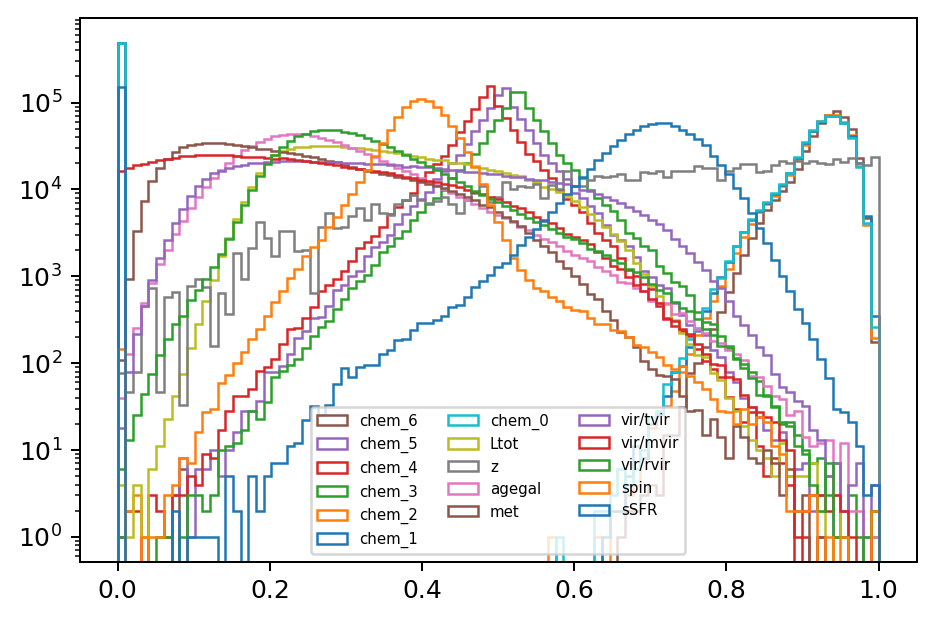

In [9]:
_ = plt.hist(
    df_norm.values, bins=np.linspace(0, 1, 100), histtype="step", label=df_norm.columns
)
plt.yscale("log")
# plt.loglog()
plt.legend(fontsize=6, ncol=3, loc="lower center")

In [14]:
logger.setLevel(10)

sample = slice(None)
# sample = np.random.choice(len(df_norm), size=400_000, replace=False)
data = np.ascontiguousarray(df_norm.values[sample])
N, d = find_dimensionality(
    data,
    bins=np.geomspace(2e-2, 10e0, 20),
    Nsample=20,
    use_MST=True,
    min_neigh=10,
    max_neigh=20,
)

dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(d))[:, None]

astrophyics_toolset: [INFO     ] 2022-03-24 20:05:04,209 Building KD-tree
astrophyics_toolset: [INFO     ] 2022-03-24 20:05:05,787 Finding nearest neighbours
astrophyics_toolset: [INFO     ] 2022-03-24 20:11:09,881 Building graph
astrophyics_toolset: [INFO     ] 2022-03-24 20:11:12,072 Adding edges until graph is connected
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:12:51,933 n_neigh10: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:12:58,105 n_neigh11: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:13:04,659 n_neigh12: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:13:12,242 n_neigh13: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:13:20,946 n_neigh14: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:13:30,564 n_neigh15: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:13:42,344 n_neigh16: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:13:54,073 n_neigh17: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 20:14:05,432 n_neigh18: ✖
astrophyics_toolset: [DEBUG    ] 2022-03-24 2

  0%|          | 0/20 [00:00<?, ?it/s]

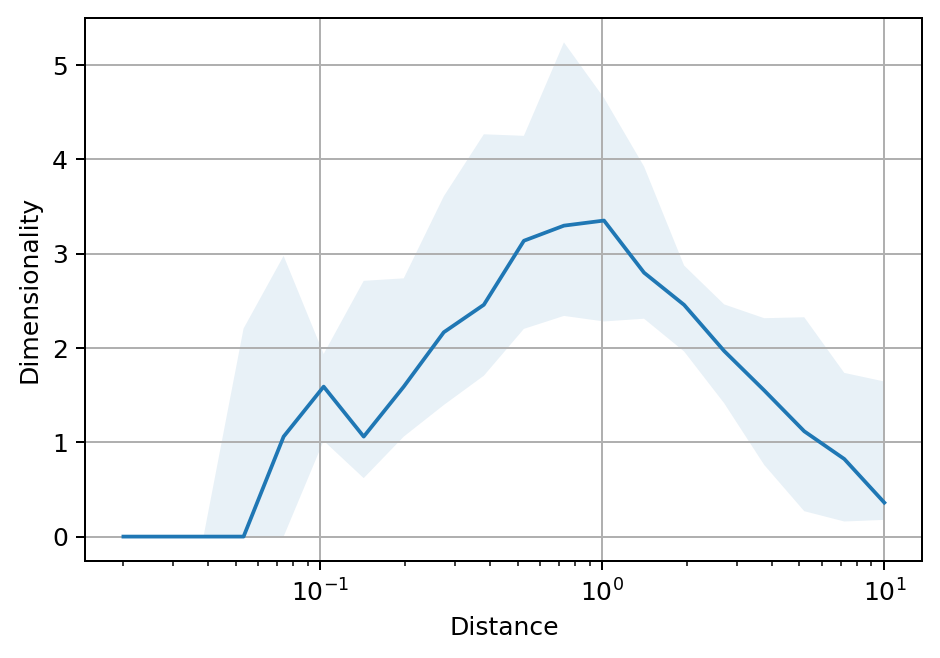

In [15]:
x = d
y = dN_dd
ylow, ymed, yup = np.percentile(dN_dd, q=[10, 50, 90], axis=1)
fig, ax = plt.subplots()
ax.plot(d, ymed)
ax.fill_between(d, ylow, yup, alpha=0.1)
ax.set(
    xscale="log",
    xlabel="Distance",
    ylabel="Dimensionality",
)
plt.grid(True)

In [17]:
from IPython.display import Markdown as md

md(
    f"The initial dimensionality is {data.shape[1]}. From the look of the plot below, it seems that the intrinsic dimensionality is ~3-4 at most."
)

The initial dimensionality is 16. From the look of the plot below, it seems that the intrinsic dimensionality is ~3-4 at most.

## Data from mock catalogues
Using data from [Laigle et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486.5104L/abstract) and [Davidzon et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.4817D/abstract). Description of columns available at https://www.horizon-simulation.org/PHOTOCAT/README_HZAGN_LAIGLE-DAVIDZON_2019.

Issue: some quantities are not varying continuously, for example the SFR is either 0 or larger than some threshold value. This means that the graph _cannot_ be connected there are jumps in some of the value that split the graph in distinct components.

In [5]:
%bash (cd tmp/ && wget -c https://www.horizon-simulation.org/PHOTOCAT/HorizonAGN_LAIGLE-DAVIDZON+2019_COSMOS_v1.6.fits)

--2022-03-24 20:45:40--  https://www.horizon-simulation.org/PHOTOCAT/HorizonAGN_LAIGLE-DAVIDZON+2019_COSMOS_v1.6.fits
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.horizon-simulation.org (www.horizon-simulation.org)... 194.57.221.229
Connecting to www.horizon-simulation.org (www.horizon-simulation.org)|194.57.221.229|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [2]:
hdul = fits.open("tmp/HorizonAGN_LAIGLE-DAVIDZON+2019_COSMOS_v1.6.fits")
hdr = hdul[1].header
hdd = hdul[1].data

df = pd.DataFrame(
    {
        col.name: hdd.field(col.name).astype(
            str(hdd.field(col.name).dtype).replace(">", "=")
        )
        for col in tqdm(hdd.columns)
    },
)

NameError: name 'fits' is not defined

In [6]:
new_data = {}

for column in (
    col
    for col in df.columns
    if col.endswith(("sedf", "TOT")) and "UP" not in col and "DOWN" not in col
):
    tmp = df[column].copy()
    if len(np.unique(tmp)) < 100:
        continue

    q1, q5, q9 = tmp.quantile(q=[0.01, 0.5, 0.99])
    if q1 == 0:
        vmin = tmp[tmp > 0].min() / 2
        tmp += vmin
        q1, q5, q9 = (_ + vmin for _ in (q1, q5, q9))

    if q5 / q1 > 5 or q9 / q5 > 5:
        print(f"{column} ⇒ log")
        tmp = normalize_log(tmp)
    else:
        print(f"{column} ⇒ lin", q1, q5, q9)
        tmp = normalize_lin(tmp)

    # We reject any column that has “holes” in it
    if (np.histogram(tmp, bins=np.linspace(0, 1, 25))[0] == 0).sum() > 10:
        continue
    new_data[column] = tmp
df_norm = pd.DataFrame(new_data)

ZMED_sedf ⇒ log
ZBEST_sedf ⇒ log


/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


MMED_sedf ⇒ lin 7.54328 9.265435 10.65008
MBEST_sedf ⇒ lin 7.4826153 9.29681 10.6620847
SFRMED_sedf ⇒ lin -1.9227647 0.40311 1.4817393999999995
LNUV_BEST_sedf ⇒ lin 6.967 9.216 10.361
LR_BEST_sedf ⇒ lin 7.429 9.131 10.248
LK_BEST_sedf ⇒ lin 6.578 8.263 9.451
u_TOT ⇒ lin -99.0 25.994155 29.319136399999994
B_TOT ⇒ lin 22.2594936 25.925075 28.7465329
V_TOT ⇒ lin 21.700042 25.65951 28.4669141
r_TOT ⇒ lin 21.3293885 25.55025 28.2306435
ip_TOT ⇒ lin 20.8177571 25.40306 28.134268699999996
zpp_TOT ⇒ lin 20.439321800000002 25.15999 28.20862
Y_TOT ⇒ lin 20.269062400000003 24.962775 28.214076899999995
J_TOT ⇒ lin 20.0615819 24.60541 27.9609447
H_TOT ⇒ lin 19.83576 24.26607 27.604575799999996
Ks_TOT ⇒ lin 19.6868412 24.10834 27.427184699999998
IA427_TOT ⇒ lin -99.0 25.792724999999997 28.96465
IA464_TOT ⇒ lin 19.137799399999995 25.74965 28.881628199999998
IA484_TOT ⇒ lin 20.6846451 25.69223 28.801994699999998
IA505_TOT ⇒ lin 20.858211 25.65731 28.785742299999995
IA527_TOT ⇒ lin 20.882218 25.620735 

<matplotlib.legend.Legend object at 0x7ff77c3496a0>

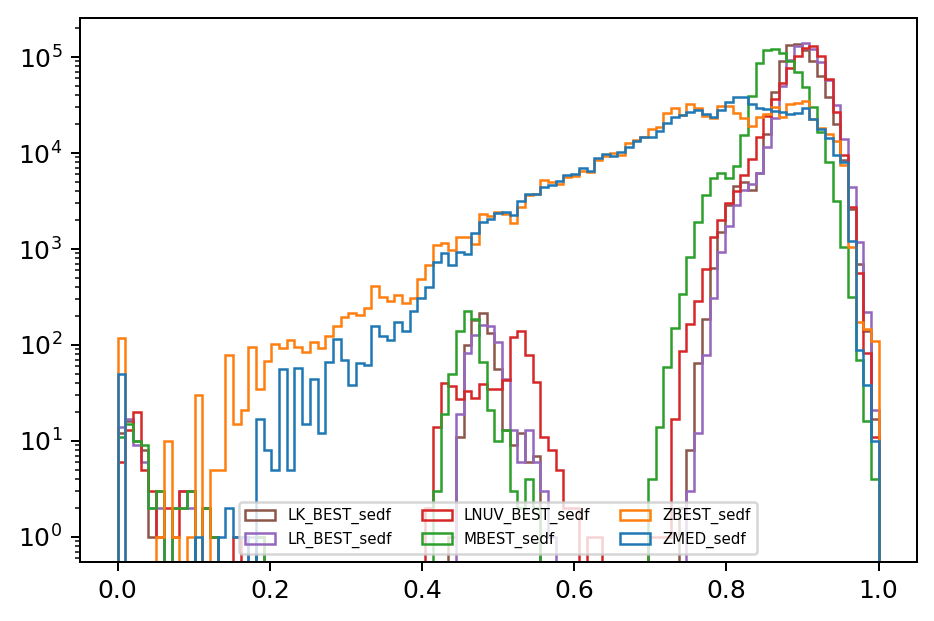

In [7]:
_ = plt.hist(
    df_norm.values, bins=np.linspace(0, 1, 100), histtype="step", label=df_norm.columns
)
plt.yscale("log")
# plt.loglog()
plt.legend(fontsize=6, ncol=3, loc="lower center")

In [ ]:
logger.setLevel(10)

# #ample = = np.random.choice(len(df_norm), size=100_000, replace=False)
data = np.ascontiguousarray(df_norm.values[sample])
N, d = find_dimensionality(
    data,
    bins=np.geomspace(2e-2, 4e0, 20),
    Nsample=20,
    use_MST=True,
    min_neigh=2,
    n_jobs=1,
)

dN_dd = np.gra4ient(np.log(N), axis=0) / np.gradient(np.log(d))[:, None]

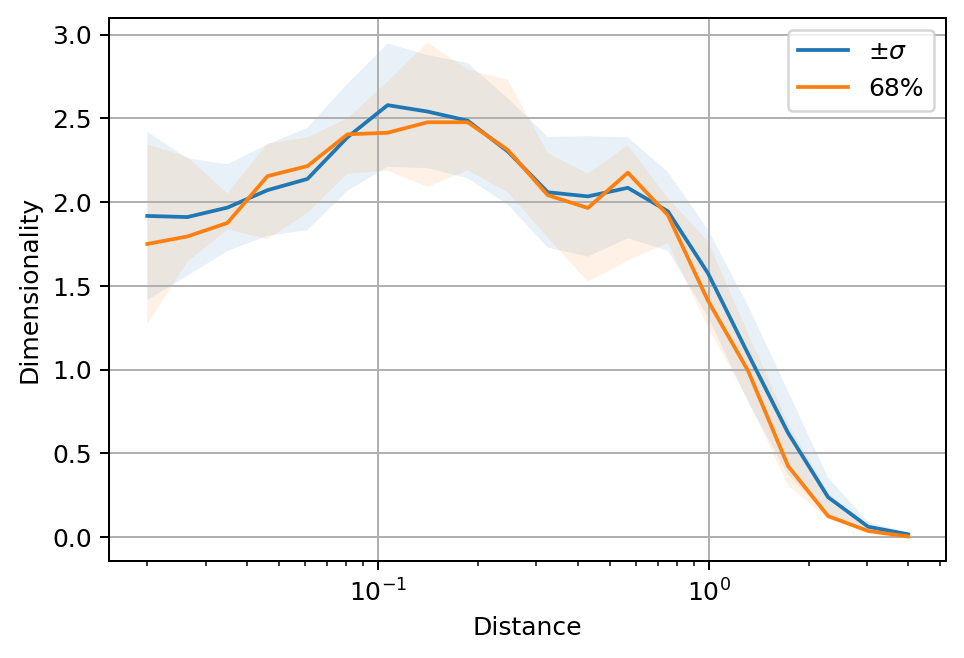

In [11]:
x = d
y = dN_dd
# ylow, ymed, yup = np.percentile(dN_dd, q=[5, 50, 95], axis=1)

fig, ax = plt.subplots()
ymed = np.mean(dN_dd, axis=1)
ystd = np.std(dN_dd, axis=1)
ylow, yup = ymed - ystd / 2, ymed + ystd / 2
ax.plot(d, ymed, label=r"$\pm \sigma$")
ax.fill_between(d, ylow, yup, alpha=0.1)

ylow, ymed, yup = np.percentile(dN_dd, q=[68 / 2, 50, 100 - 68 / 2], axis=1)
ax.plot(d, ymed, label="68%")
ax.fill_between(d, ylow, yup, alpha=0.1)

ax.legend()
ax.set(
    xscale="log",
    xlabel="Distance",
    ylabel="Dimensionality",
)
plt.grid(True)

In [13]:
from IPython.display import Markdown as md

md(
    f"The initial dimensionality is {data.shape[1]}. From the look of the plot below, it seems that the intrinsic dimensionality is ~2-3 at most."
)

The initial dimensionality is 6. From the look of the plot below, it seems that the intrinsic dimensionality is ~2-3 at most.

## Data from mock catalogues - using magnitudes
Using data from [Laigle et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486.5104L/abstract) and [Davidzon et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.4817D/abstract). Description of columns available at https://www.horizon-simulation.org/PHOTOCAT/README_HZAGN_LAIGLE-DAVIDZON_2019.

In [14]:
%bash (cd tmp/ && wget -c https://www.horizon-simulation.org/PHOTOCAT/HorizonAGN_LAIGLE-DAVIDZON+2019_COSMOS_v1.6.fits)

UsageError: Line magic function `%bash` not found (But cell magic `%%bash` exists, did you mean that instead?).


In [4]:
hdul = fits.open("tmp/HorizonAGN_LAIGLE-DAVIDZON+2019_COSMOS_v1.6.fits")
hdr = hdul[1].header
hdd = hdul[1].data

df = pd.DataFrame(
    {
        col.name: hdd.field(col.name).astype(
            str(hdd.field(col.name).dtype).replace(">", "=")
        )
        for col in tqdm(hdd.columns)
    },
)

  0%|          | 0/119 [00:00<?, ?it/s]

In [5]:
new_data = {}

for column in (
    col
    for col in df.columns
    if col.endswith("TOTnoerr") and "UP" not in col and "DOWN" not in col
):
    tmp = df[column].copy()
    if len(np.unique(tmp)) < 100:
        continue

    q1, q5, q9 = tmp.quantile(q=[0.01, 0.5, 0.99])
    if q1 == 0:
        vmin = tmp[tmp > 0].min() / 2
        tmp += vmin
        q1, q5, q9 = (_ + vmin for _ in (q1, q5, q9))

    if q5 / q1 > 5 or q9 / q5 > 5:
        print(f"{column} ⇒ log")
        tmp = normalize_log(tmp)
    else:
        print(f"{column} ⇒ lin", q1, q5, q9)
        tmp = normalize_lin(tmp)
    new_data[column] = tmp
df_norm = pd.DataFrame(new_data)

u_TOTnoerr ⇒ lin 23.1517006 26.23082 32.5811723
B_TOTnoerr ⇒ lin 22.810988299999998 25.942365000000002 28.6706541
V_TOTnoerr ⇒ lin 22.0789653 25.681154999999997 28.051262899999998
r_TOTnoerr ⇒ lin 21.5326512 25.5647 27.81219
ip_TOTnoerr ⇒ lin 20.9772606 25.42716 27.494419399999998
zpp_TOTnoerr ⇒ lin 20.6519548 25.21306 27.167382899999996
Y_TOTnoerr ⇒ lin 20.507216500000002 25.052785 27.0226041
J_TOTnoerr ⇒ lin 20.2343212 24.67745 26.718238799999998
H_TOTnoerr ⇒ lin 19.949550600000002 24.34387 26.276764699999998
Ks_TOTnoerr ⇒ lin 19.7718707 24.191735 25.935202899999997
IA427_TOTnoerr ⇒ lin 22.904345900000003 25.981485 36.939442699999994
IA464_TOTnoerr ⇒ lin 22.6934553 25.86499 28.45816569999999
IA484_TOTnoerr ⇒ lin 22.569780700000003 25.79524 28.302220499999997
IA505_TOTnoerr ⇒ lin 22.3952143 25.75527 28.2106276
IA527_TOTnoerr ⇒ lin 22.2343577 25.71124 28.133372899999998
IA574_TOTnoerr ⇒ lin 21.8767261 25.63025 28.027882899999998
IA624_TOTnoerr ⇒ lin 21.5312271 25.55969 27.8291769999999

In [6]:
df_norm.shape

(789354, 26)

<matplotlib.legend.Legend object at 0x7fe1f5dd89d0>

<Figure size 1080x720 with 1 Axes>

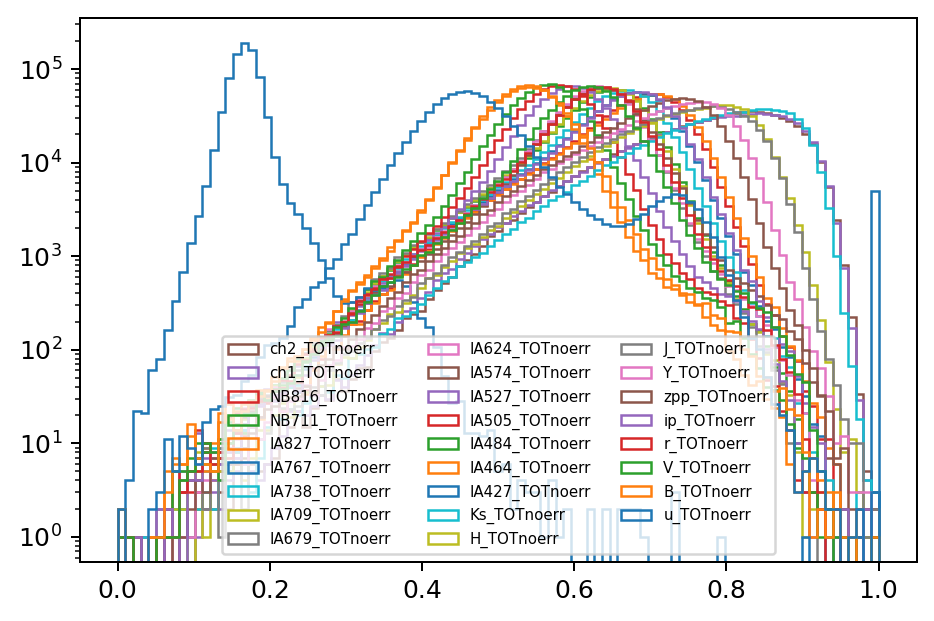

In [7]:
_ = plt.hist(
    df_norm.values, bins=np.linspace(0, 1, 100), histtype="step", label=df_norm.columns
)
plt.yscale("log")
# plt.loglog()
plt.legend(fontsize=6, ncol=3, loc="lower center")

In [123]:
logger.setLevel(10)

# sample = np.random.choice(len(df_norm), size=200_000, replace=False)
sample = slice(None)
data = np.ascontiguousarray(df_norm.values[sample])
N, d = find_dimensionality(
    data,
    bins=np.geomspace(1e-2, 2, 20),
    Nsample=20,
    use_MST=False,
    min_neigh=5,
    n_jobs=2,
    n_min_connected_components=1,
)

dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(d))[:, None]

astrophyics_toolset: [INFO     ] 2022-04-12 17:24:58,769 Building KD-tree
astrophyics_toolset: [INFO     ] 2022-04-12 17:25:00,048 Finding nearest neighbours
astrophyics_toolset: [INFO     ] 2022-04-12 17:26:30,377 Building graph
astrophyics_toolset: [INFO     ] 2022-04-12 17:26:31,363 Adding edges until graph is connected
astrophyics_toolset: [DEBUG    ] 2022-04-12 17:26:43,219 n_neigh5: ✖
astrophyics_toolset: [DEBUG    ] 2022-04-12 17:26:47,242 n_neigh6: ✖
astrophyics_toolset: [DEBUG    ] 2022-04-12 17:26:51,858 n_neigh7: ✖
astrophyics_toolset: [DEBUG    ] 2022-04-12 17:26:56,943 n_neigh8: ✔
astrophyics_toolset: [INFO     ] 2022-04-12 17:26:56,944 Computing number of point as a function of distance


Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
x = d
y = dN_dd
# ylow, ymed, yup = np.percentile(dN_dd, q=[5, 50, 95], axis=1)

fig, ax = plt.subplots()
ymed = np.mean(dN_dd, axis=1)
ystd = np.std(dN_dd, axis=1)
ylow, yup = ymed - ystd / 2, ymed + ystd / 2
ax.plot(d, ymed, label=r"$\pm \sigma$")
ax.fill_between(d, ylow, yup, alpha=0.1)

ylow, ymed, yup = np.percentile(dN_dd, q=[68 / 2, 50, 100 - 68 / 2], axis=1)
ax.plot(d, ymed, label="68%")
ax.fill_between(d, ylow, yup, alpha=0.1)

ax.legend()
ax.set(
    xscale="log",
    xlabel="Distance",
    ylabel="Dimensionality",
)
plt.grid(True)

In [ ]:
x = d
y = np.mean(np.gradient(N, axis=0) / np.gradient(d)[:, None], axis=1)

imax = np.argmax(y)
xmax, ymax = x[imax], y[imax]

fix, ax = plt.subplots()
ax.loglog(x / xmax, y / ymax, label="Data", c="black")

for dim in range(1, 4):
    xx = x / xmax * np.pi / 2
    ax.loglog(
        x / xmax, np.sin(xx) ** (dim - 1), ls="--", label=rf"$N_\mathrm{{dim}}={dim}$"
    )

ax.set(
    xlabel=r"$r/r_\mathrm{max}$",
    ylabel=r"$p/p_\mathrm{max}$",
)
ax.grid(True)
ax.legend()

In [ ]:
from IPython.display import Markdown as md

md(
    f"The initial dimensionality is {data.shape[1]}. From the look of the plot below, "
    "it seems that the intrinsic dimensionality is ~3-4 at most."
)

### Using pre-reducing dimensionality

In [7]:
from sklearn import manifold
from sklearn import decomposition

In [9]:
sample = np.random.choice(len(df_norm), size=10_000, replace=False)

decomp = manifold.Isomap(n_components=10, n_neighbors=5)
decomp = decomposition.PCA(n_components=15, svd_solver="full")
decomp.fit(df_norm.values[sample])

/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:304: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Isomap(n_components=10)

In [11]:
X_transformed = decomp.transform(df_norm.values[sample])


KeyboardInterrupt



In [ ]:
logger.setLevel(10)

sample = np.random.choice(len(X_transformed), size=200_000, replace=False)
# sample = slice(None)
data = np.ascontiguousarray(X_transformed[sample])
N, d = find_dimensionality(
    data,
    bins=np.geomspace(1e-2, 2, 20),
    Nsample=20,
    use_MST=False,
    min_neigh=5,
    n_jobs=2,
    n_min_connected_components=2,
)

dN_dd = np.gradient(np.log(N), axis=0) / np.gradient(np.log(d))[:, None]

In [ ]:
x = d
y = dN_dd
# ylow, ymed, yup = np.percentile(dN_dd, q=[5, 50, 95], axis=1)

fig, ax = plt.subplots()
ymed = np.mean(dN_dd, axis=1)
ystd = np.std(dN_dd, axis=1)
ylow, yup = ymed - ystd / 2, ymed + ystd / 2
ax.plot(d, ymed, label=r"$\pm \sigma$")
ax.fill_between(d, ylow, yup, alpha=0.1)

ylow, ymed, yup = np.percentile(dN_dd, q=[68 / 2, 50, 100 - 68 / 2], axis=1)
ax.plot(d, ymed, label="68%")
ax.fill_between(d, ylow, yup, alpha=0.1)

ax.legend()
ax.set(
    xscale="log",
    xlabel="Distance",
    ylabel="Dimensionality",
)
plt.grid(True)

In [ ]:
x = d
y = np.mean(np.gradient(N, axis=0) / np.gradient(d)[:, None], axis=1)

imax = np.argmax(y)
xmax, ymax = x[imax], y[imax]

fix, ax = plt.subplots()
ax.loglog(x / xmax, y / ymax, label="Data", c="black")

for dim in range(1, 4):
    x = np.linspace(x.min(), x.max(), 1000)
    xx = x / xmax * np.pi / 2
    ax.loglog(
        x / xmax, np.sin(xx) ** (dim - 1), ls="--", label=rf"$N_\mathrm{{dim}}={dim}$"
    )

ax.set(
    xlabel=r"$r/r_\mathrm{max}$",
    ylabel=r"$p/p_\mathrm{max}$",
)
ax.grid(True)
ax.legend()

### Try using tensorflow

Here, we use a Machine learning approach by compressing our dataset to a few latent variables before expanding them again. How well this performs informs us of the minimal number of latent variables sufficient to encode the data.

To that end, we use a variable auto encoder

In [45]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [47]:
mask = np.ones(len(df_norm), dtype=bool)
tmp = np.random.choice(len(mask), size=len(mask)//20, replace=False)
mask[tmp] = False
(x_train, x_test) = df_norm[mask].values, df_norm[~mask].values

In [73]:
input_shape = df_norm.shape[1:]
encoded_size = 10
base_depth = 32

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Dense(base_depth, activation=tf.nn.leaky_relu),
    tfkl.Dense(4 * encoded_size, activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=1.0)),
])

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Dense(4 * encoded_size, activation=tf.nn.leaky_relu),
    tfkl.Dense(np.product(input_shape)),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    loss=negloglik
)

In [74]:
encoder.summary()
decoder.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_10 (Lambda)          (None, 26)                0         
                                                                 
 dense_124 (Dense)           (None, 32)                864       
                                                                 
 dense_125 (Dense)           (None, 40)                1320      
                                                                 
 flatten_4 (Flatten)         (None, 40)                0         
                                                                 
 dense_126 (Dense)           (None, 65)                2665      
                                                                 
 multivariate_normal_tri_l_1  ((None, 10),             0         
 0 (MultivariateNormalTriL)   (None, 10))                        
                                                     

In [75]:
_ = vae.fit(
    x=x_train,
    y=x_train,
    batch_size=1000,
    epochs=10,
    validation_data=(x_test, x_test),
)

Epoch 1/10
750/750 [==============================] - 54s 70ms/step - loss: 16.6338 - val_loss: 16.4065
Epoch 2/10
750/750 [==============================] - 51s 68ms/step - loss: 16.4063 - val_loss: 16.3924
Epoch 3/10
750/750 [==============================] - 65s 86ms/step - loss: 16.4015 - val_loss: 16.3929
Epoch 4/10
750/750 [==============================] - 43s 57ms/step - loss: 16.4004 - val_loss: 16.3936
Epoch 5/10
233/750 [========>.....................] - ETA: 43s - loss: 16.3995

KeyboardInterrupt: 

In [ ]:
latent_dim = 10
input_dim = df_norm.shape[1]


class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim: int, input_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = round(np.sqrt(latent_dim * input_dim * 2))
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.hidden_dim, activation='relu'),
            tf.keras.layers.Dense(self.latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_dim, activation='sigmoid'),
            tf.keras.layers.Dense(self.input_dim, activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim, input_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [32]:
autoencoder.vae.fit(
    x=x_train,
    y=x_train,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/10


TypeError: in user code:

    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/metrics.py", line 455, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/home/ccc/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_9'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [66]:
encoded_vals = autoencoder.encoder(x_test).numpy()
decoded_vals = autoencoder.decoder(encoded_vals).numpy()

In [95]:
i = -1

<Figure size 1080x720 with 1 Axes>

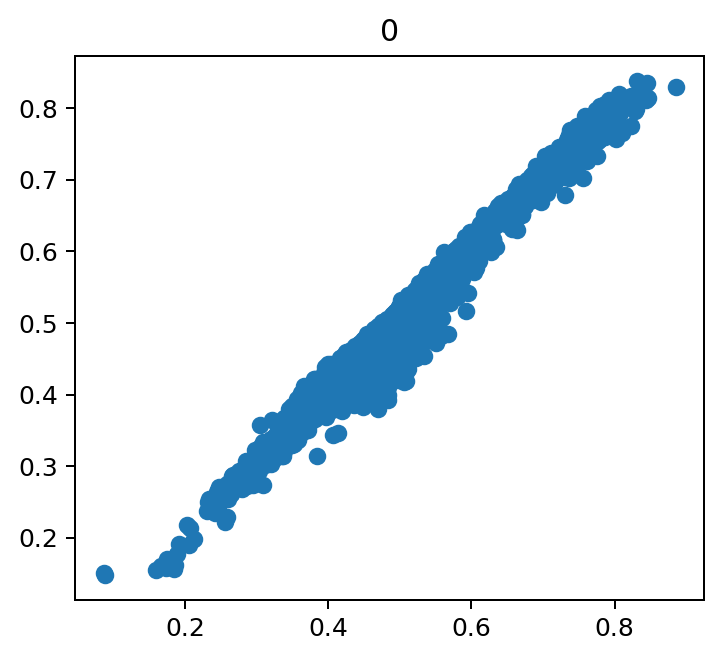

In [96]:
i += 1
plt.scatter(x_test[:, i], decoded_vals[:, i])
plt.title(str(i))
plt.gca().set_aspect("equal")

In [112]:
encoded_vals[:, 6].ptp()

0.0